# Modelo de Árvores de Decisão (Naufrágio do Titanic)

##### Bibliotecas importadas

In [451]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import plotly.offline as pof
import plotly.graph_objs as pgo
import plotly.tools as pto
import sklearn as skt
import PIL

from IPython.display import Image

pof.init_notebook_mode(connected=True)

##### Aquisição e tratamento de dados

In [452]:
test_file = pd.read_csv('test.csv')
train_file = pd.read_csv('train.csv')
df_train = pd.DataFrame(train_file)
df_test = pd.DataFrame(test_file)
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

In [453]:
# conversão de qualified features em categorized features
# as qualified features serão transformadas em tabelas booleanas

##### Busca por valores Null ou vazios

Os vazios são interpretados como buracos no modelo que precisam ser tratados ou substituídos, ou removidos, dependendo da situação, no caso presente, os dados foram substituídos com a média da própria idade dos passageiros.

In [454]:
nulos = {'train': df_train.isnull().sum().sort_values(ascending=False), 'test': df_test.isnull().sum().sort_values(ascending=False)}
nulos_df = pd.DataFrame(nulos)
nulos_df

,train,test
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


In [455]:
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

# Quantificação de parentes por membro da tripulação
df_train['Family Members'] = df_train.loc[0:, ['Parch', 'SibSp']].sum(axis=1)
df_test['Family Members'] = df_test.loc[0:, ['Parch', 'SibSp']].sum(axis=1)

all_data = pd.merge(df_train, df_test, how='outer')

df_train.drop(['Parch', 'SibSp','PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)
df_test.drop(['Parch', 'SibSp', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)

# identificação se o passageiro teve cabine ou não
pointer = []
for item in df_train['Cabin']:
    if type(item) is float:
        pointer.append(0)
    else:
        pointer.append(1)
df_train['Has Cabin'] = pointer
df_train.drop(['Cabin'], axis=1, inplace=True)

pointer.clear()
for item in df_test['Cabin']:
    if type(item) is float:
        pointer.append(0)
    else:
        pointer.append(1)
df_test['Has Cabin'] = pointer
df_test.drop(['Cabin'], axis=1, inplace=True)

pointer.clear()

for index, item in enumerate(df_train['Embarked']):
    if type(item) == str:
        pointer.append(item)
    else:
        pointer.append(0)
        df_train.drop(index=index, axis=0, inplace=True)

Quantos familiares estavam embarcados por pessoa?

In [456]:
nulos = {
'Test': df_test.isnull().sum().sort_values(ascending=False),
'Train': df_train.isnull().sum().sort_values(ascending=False)
}
nulos_df = pd.DataFrame(nulos)
nulos_df
# sem valores nulos

,Test,Train
Age,0.0,0
Embarked,0.0,0
Family Members,0.0,0
Fare,0.0,0
Has Cabin,0.0,0
Pclass,0.0,0
Sex,0.0,0
Survived,NaN,0


In [457]:
new_data_train = pd.get_dummies(df_train)
new_data_test = pd.get_dummies(df_test)

<AxesSubplot:title={'center':'Mapa de Calor: Correlações entre os componentes'}>

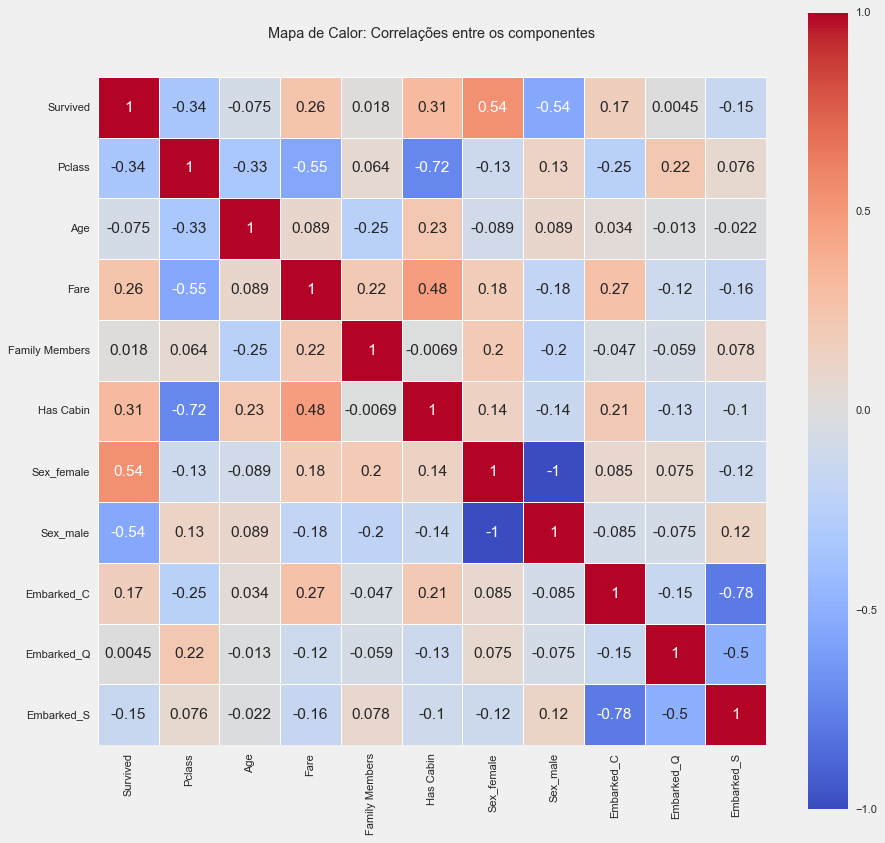

In [458]:
colormap = plt.cm.coolwarm
plt.figure(figsize=(12,12))
plt.title('Mapa de Calor: Correlações entre os componentes', y=1.05, size=13)
sns.heatmap(new_data_train.astype(float).corr(),linewidths=0.5,vmax=1.0, vmin=-1, square=True, cmap=colormap, linecolor='white', annot=True)

##### Criando a Árvore de Decisão
Vamos definir as features para o modelo e o seu target

In [459]:
all_men = len(new_data_train[new_data_train.Sex_male > 0])
all_men_survived = len(new_data_train[(new_data_train.Sex_male == 1) & (new_data_train.Survived == 1)])
all_women = len(new_data_train[new_data_train.Sex_female > 0])
all_women_survived = len(new_data_train[(new_data_train.Sex_female == 1) & (new_data_train.Survived == 1)])

<Figure size 1280x720 with 0 Axes>

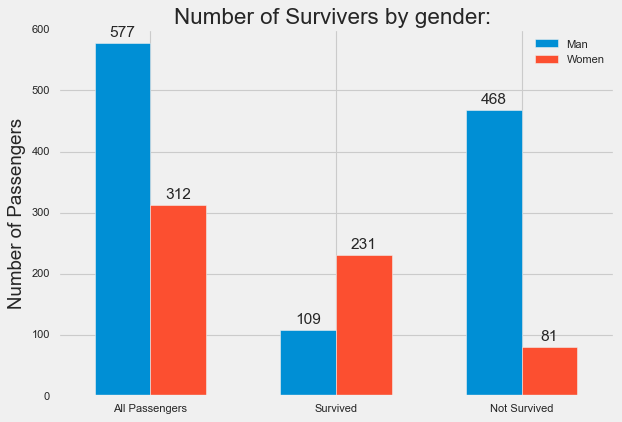

In [460]:
plt.figure(figsize=(16, 9))
plt.style.use('fivethirtyeight')
labels = ['All Passengers', 'Survived', 'Not Survived']
level = 0
men_axes = [all_men, all_men_survived, all_men - all_men_survived]
women_axes = [all_women, all_women_survived, all_women - all_women_survived]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars
man = 'Man'
woman = 'Women'
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_axes, width, label=man)
rects2 = ax.bar(x + width/2, women_axes, width, label=woman)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Passengers')
ax.set_title('Number of Survivers by gender: ')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [461]:


survived_vs_class = new_data_train[['Pclass', 'Survived', 'Sex_male', 'Sex_female']]

C:\Users\alana\AppData\Local\Temp\ipykernel_33220\4063519884.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 960x720 with 0 Axes>

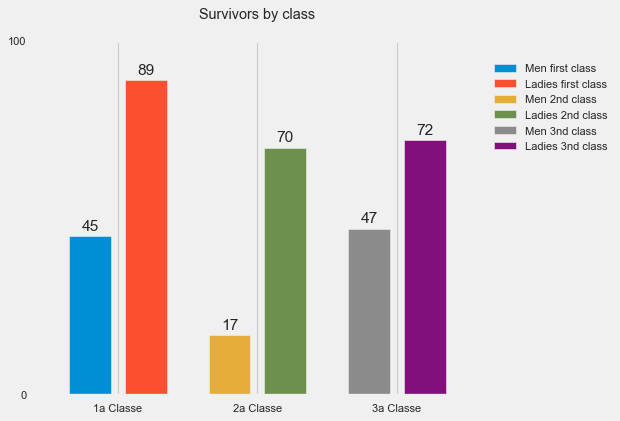

In [464]:
survives = survived_vs_class[(survived_vs_class.Survived > 0)]
survives.drop(['Survived'], axis=1, inplace=True)
labels = ['1a Classe', '2a Classe', '3a Classe']
plt.figure(figsize=(12, 9))
width = 0.15
x = np.arange(1)
fig, ax = plt.subplots()
c1 = ax.bar(x -0.60, len(survives[(survives.Pclass == 1) & (survives.Sex_male == 1)]), width, label='Men first class')
c2 = ax.bar(x -0.40, len(survives[(survives.Pclass == 1) & (survives.Sex_female == 1)]), width, label='Ladies first class')
c3 = ax.bar(x - 0.10, len(survives[(survives.Pclass == 2) & (survives.Sex_male == 1)]), width, label='Men 2nd class')
c4 = ax.bar(x + 0.10, len(survives[(survives.Pclass == 2) & (survives.Sex_female == 1)]), width, label='Ladies 2nd class')
c5 = ax.bar(x + 0.40, len(survives[(survives.Pclass == 3) & (survives.Sex_male == 1)]), width, label='Men 3nd class')
c6 = ax.bar(x+ 0.60, len(survives[(survives.Pclass == 3) & (survives.Sex_female == 1)]), width, label='Ladies 3nd class')



ax.legend(bbox_to_anchor=(1.02, 0.95), loc=2, borderaxespad=0.)
ax.set_title('Survivors by class', y=1.05, size=13)
ax.set_xticks([-0.50, 0, 0.50], labels=labels)
ax.set_yticks([0, 100])

ax.bar_label(c1, padding=3)
ax.bar_label(c2, padding=3)
ax.bar_label(c3, padding=3)
ax.bar_label(c4, padding=3)
ax.bar_label(c5, padding=3)
ax.bar_label(c6, padding=3)
fig.tight_layout()
plt.show()

Criando o modelo

In [463]:
Y = new_data_train['Survived']
X = new_data_train.drop(['Survived'], axis=1)

tree = skt.tree.DecisionTreeClassifier(max_depth=8, random_state=0)
tree.fit(X, Y)

AttributeError: module 'sklearn' has no attribute 'tree'

In [ ]:
tree.score(X, Y)